The code worked here is solely intended for conceptual understanding and algorithmic exploration. It is not designed for any state-of-the-art comparisons, performance optimization, or benchmark evaluations. The purpose is to aid in grasping the fundamental workings of the algorithm rather than achieving competitive performance metrics. The code will not require any gpu to run

In [1]:
!pip install torch-geometric

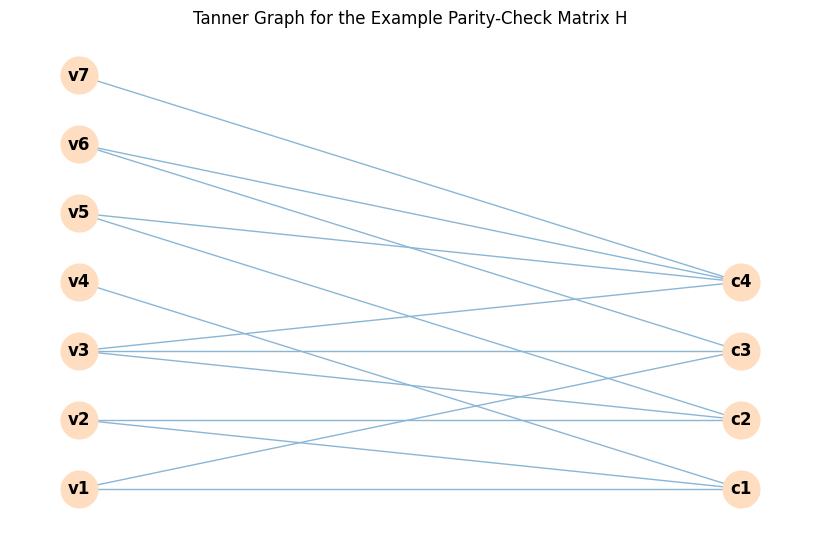

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the parity-check matrix H
H = [
    [1, 1, 0, 1, 0, 0, 0],
    [0, 1, 1, 0, 1, 0, 0],
    [1, 0, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 1, 1, 1]
]

# Number of check nodes (rows) and variable nodes (columns)
num_cn = len(H)
num_vn = len(H[0])

# Create a bipartite graph for the Tanner graph representation
G = nx.Graph()

# Add variable nodes (v1, v2, ..., v7)
for vn in range(num_vn):
    G.add_node(f'v{vn+1}', bipartite=0)

# Add check nodes (c1, c2, ..., c4)
for cn in range(num_cn):
    G.add_node(f'c{cn+1}', bipartite=1)

# Add edges according to the parity-check matrix
for cn in range(num_cn):
    for vn in range(num_vn):
        if H[cn][vn] == 1:
            G.add_edge(f'c{cn+1}', f'v{vn+1}')

# Plotting the Tanner Graph
plt.figure(figsize=(8, 5))

# Positioning nodes for bipartite graph layout
pos = {}
pos.update((f'v{vn+1}', (1, vn)) for vn in range(num_vn))  # variable nodes on one side
pos.update((f'c{cn+1}', (2, cn)) for cn in range(num_cn))  # check nodes on the other side

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_size=700, node_color="#FFDDC1", edge_color="#8AB6D6", font_weight="bold")
plt.title("Tanner Graph for the Example Parity-Check Matrix H")
plt.show()


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
import torch.nn as nn
from torch.optim import Adam
import numpy as np

class LDPCDecoder(MessagePassing):
    def __init__(self, node_features, message_dim, num_iterations):
        super(LDPCDecoder, self).__init__(aggr='add')
        self.message_dim = message_dim
        self.num_iterations = num_iterations  # Number of message-passing iterations per epoch

        # Define multiple layers for message transformation with higher capacity
        self.lin_message_1 = nn.Linear(node_features, message_dim)
        self.lin_message_2 = nn.Linear(message_dim, message_dim)
        self.lin_message_3 = nn.Linear(message_dim, message_dim)

        # Define multiple layers for update transformation with higher capacity
        self.lin_update_1 = nn.Linear(message_dim, message_dim)
        self.lin_update_2 = nn.Linear(message_dim, message_dim)
        self.lin_update_3 = nn.Linear(message_dim, node_features)

    def forward(self, x, edge_index):
        # Perform multiple rounds of message passing
        for _ in range(self.num_iterations):
            x = self.propagate(edge_index, x=x)
        return x

    def message(self, x_j):
        # Pass through multiple layers and apply sigmoid for belief propagation
        x_j = F.relu(self.lin_message_1(x_j))
        x_j = F.relu(self.lin_message_2(x_j))
        x_j = torch.sigmoid(self.lin_message_3(x_j))
        return x_j

    def update(self, aggr_out, x):
        # Pass through multiple layers and apply ReLU activation for the update
        aggr_out = F.relu(self.lin_update_1(aggr_out))
        aggr_out = F.relu(self.lin_update_2(aggr_out))
        return F.relu(self.lin_update_3(aggr_out) + x)

def create_ldpc_graph(H):
    num_checks, num_variables = H.shape
    edges = []
    for i in range(num_checks):
        for j in range(num_variables):
            if H[i, j] == 1:
                edges.append([j, num_variables + i])
                edges.append([num_variables + i, j])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index, num_checks + num_variables

def generate_codeword(H):
    n_variable_nodes = H.shape[1]
    codeword = torch.randint(0, 2, (n_variable_nodes,), dtype=torch.float32)
    while (H @ codeword % 2).sum() != 0:
        codeword = torch.randint(0, 2, (n_variable_nodes,), dtype=torch.float32)
    return codeword

def add_noise(codeword, noise_level=0.5):
    noise = torch.randn_like(codeword) * noise_level
    return codeword + noise

# Larger LDPC code setup (8x16 matrix)
H = torch.tensor([
    [1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
    [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
    [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1],
    [1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0],
    [0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1],
    [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0]
], dtype=torch.float32)

edge_index, num_nodes = create_ldpc_graph(H)
node_features = 2
message_dim = 8  # Increased message dimension for larger model
iterations_per_epoch = 5  # Number of message-passing rounds per epoch
batch_size = 10  # Number of codewords per batch

# Initialize the LDPC Decoder model with multiple iterations per epoch
model = LDPCDecoder(node_features, message_dim, iterations_per_epoch)
optimizer = Adam(model.parameters(), lr=0.01)

# Training loop for multiple codewords
epochs = 20
for epoch in range(epochs):
    optimizer.zero_grad()

    # Initialize total loss for the batch
    total_loss = 0

    # Generate and process each codeword in the batch
    for _ in range(batch_size):
        # Generate a new codeword and add noise
        true_codeword = generate_codeword(H)
        noisy_codeword = add_noise(true_codeword)

        # Prepare the input features (noisy received signals)
        x = torch.stack([noisy_codeword, torch.zeros_like(noisy_codeword)], dim=1)
        x = torch.cat([x, torch.zeros(H.shape[0], node_features)], dim=0)  # Include check nodes with zero features

        # Create graph data for this codeword
        data = Data(x=x, edge_index=edge_index)

        # Perform forward pass and calculate loss for this codeword
        output = model(data.x, data.edge_index)
        loss = F.mse_loss(output[:H.shape[1], 0], true_codeword)  # Loss only on variable nodes
        total_loss += loss  # Accumulate loss for each codeword

    # Backpropagate and optimize using the total loss of the batch
    total_loss.backward()
    optimizer.step()

    # Print average loss for the batch
    if epoch % 1 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {total_loss.item() / batch_size}")

# Evaluate performance after training
with torch.no_grad():
    # Generate a test codeword and add noise
    test_codeword = generate_codeword(H)
    noisy_test_codeword = add_noise(test_codeword)

    # Prepare the input features for the test codeword
    x_test = torch.stack([noisy_test_codeword, torch.zeros_like(noisy_test_codeword)], dim=1)
    x_test = torch.cat([x_test, torch.zeros(H.shape[0], node_features)], dim=0)

    # Create graph data for the test codeword
    data_test = Data(x=x_test, edge_index=edge_index)

    # Run the model on the test codeword
    output_test = model(data_test.x, data_test.edge_index)

    # Calculate MSE for the test codeword
    mse_test = F.mse_loss(output_test[:H.shape[1], 0], test_codeword)

    print("Test Codeword MSE after training:", mse_test.item())
    print("Original test codeword:", test_codeword.numpy())
    print("Noisy received test codeword:", noisy_test_codeword.numpy())
    print("Decoded test codeword after training:", output_test[:H.shape[1], 0].detach().numpy())


Epoch 1/20, Average Loss: 0.20169332027435302
Epoch 2/20, Average Loss: 0.4230609893798828
Epoch 3/20, Average Loss: 0.16816152334213258
Epoch 4/20, Average Loss: 0.22632851600646972
Epoch 5/20, Average Loss: 0.25234715938568114
Epoch 6/20, Average Loss: 0.2951178550720215
Epoch 7/20, Average Loss: 0.3284505128860474
Epoch 8/20, Average Loss: 0.27770261764526366
Epoch 9/20, Average Loss: 0.24279208183288575
Epoch 10/20, Average Loss: 0.18148362636566162
Epoch 11/20, Average Loss: 0.19574841260910034
Epoch 12/20, Average Loss: 0.20967178344726561
Epoch 13/20, Average Loss: 0.21383156776428222
Epoch 14/20, Average Loss: 0.20111513137817383
Epoch 15/20, Average Loss: 0.20767877101898194
Epoch 16/20, Average Loss: 0.19264940023422242
Epoch 17/20, Average Loss: 0.16071066856384278
Epoch 18/20, Average Loss: 0.1786397933959961
Epoch 19/20, Average Loss: 0.193747878074646
Epoch 20/20, Average Loss: 0.17596936225891113
Test Codeword MSE after training: 0.25139838457107544
Original test codewor

In [ ]:
import pandas as pd

# Desired number of codewords with 0 or 1 bit mismatches
desired_num_codewords = 10
num_iterations = 2

# List to store results for each codeword and iteration
results = []
valid_codewords_found = 0  # Counter for codewords with 0 or 1 mismatch

# Loop until we find the desired number of codewords with 0 or 1 mismatch
while valid_codewords_found < desired_num_codewords:
    # Generate a new codeword and add noise
    true_codeword = generate_codeword(H)
    noisy_codeword = add_noise(true_codeword)

    # Prepare the input features (noisy received signals)
    x = torch.stack([noisy_codeword, torch.zeros_like(noisy_codeword)], dim=1)
    x = torch.cat([x, torch.zeros(H.shape[0], node_features)], dim=0)  # Include check nodes with zero features

    # Create graph data
    data = Data(x=x, edge_index=edge_index)

    # Run model for multiple iterations and calculate MSE and bit mismatches at each step
    with torch.no_grad():
        current_output = data.x.clone()  # Initial noisy input for the model

        for iteration in range(1, num_iterations + 1):
            # Pass through the model
            current_output = model(current_output, data.edge_index)

            # Calculate MSE between decoded output and true codeword (only variable nodes)
            mse = F.mse_loss(current_output[:H.shape[1], 0], true_codeword).item()

            # Clip values between 0 and 1, then round to nearest binary values
            clipped_output = torch.clamp(current_output[:H.shape[1], 0], 0, 1)
            predicted_codeword = torch.round(clipped_output).numpy()

            # Calculate the number of bit mismatches
            mismatches = np.sum(predicted_codeword != true_codeword.numpy())

            # Only store and print the best codewords
            if mismatches <= 1:
                results.append({
                    'Codeword Index': valid_codewords_found + 1,
                    'True Codeword': true_codeword.numpy(),
                    'Predicted Codeword': predicted_codeword,
                    'Iteration': iteration,
                    'MSE': mse,
                    'Bit Mismatches': mismatches
                })
                valid_codewords_found += 1
                break  # Exit the iteration loop once we have a valid match

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)

# Styling function to add borders
def style_table(df):
    styled_df = df.style
    styled_df = styled_df.set_properties(**{'border': '1px solid black'})  # Thin border between all cells

    # Add thicker borders between different codewords
    for i in range(1, len(df)):
        if df['Codeword Index'].iloc[i] != df['Codeword Index'].iloc[i - 1]:
            styled_df = styled_df.set_properties(
                subset=pd.IndexSlice[i:, :],
                **{'border-top': '3px solid black'}
            )
    return styled_df

# Display the styled table
styled_df = style_table(results_df)
styled_df


,Codeword Index,True Codeword,Predicted Codeword,Iteration,MSE,Bit Mismatches
0,1,[1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1.],[1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1.],1,0.030417,0
1,2,[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1.],[0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1.],2,0.063403,1
2,3,[0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1.],[0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1.],1,0.068318,0
3,4,[0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1.],[0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1.],1,0.125884,1
4,5,[0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.],[0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.],1,0.035659,0
5,6,[0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.],[0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.],1,0.037664,0
6,7,[1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.],[0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1.],1,0.077408,1
7,8,[0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0.],[0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0.],1,0.149258,1
8,9,[1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1.],[1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0.],2,0.110871,1
9,10,[1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.],[1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.],1,0.106452,1
